In [1]:
import os
import warnings
import pandas as pd
import seaborn as sns
from math import sqrt

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from synthesized.testing.evaluation import Evaluation
os.getcwd()
evaluation = Evaluation(config_path='synthesized/configs/evaluation/synthetic_distributions.json', name='synthetic') # use this line if you want to run this notbook manually
#evaluation = Evaluation()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3139-2DF3-5D2D-B5F3
Expires at: 2019-06-30 00:00:00


In [3]:
from synthesized.core import BasicSynthesizer

In [4]:
import numpy as np

In [5]:
def create_ball(x_mean, x_std, y_mean, y_std, size):
    mean = [x_mean, y_mean]
    cov = [[x_std, 0], [0, y_std]]
    x, y = np.random.multivariate_normal(mean, cov, size).T
    df = pd.DataFrame({'x': x, 'y': y})
    return df

In [6]:
def create_line(x_range, intercept, slope, y_std, size):
    x = np.random.uniform(low=x_range[0], high=x_range[1], size=size)
    y = intercept + x*slope + np.random.normal(loc=0, scale=y_std, size=size)
    df = pd.DataFrame({'x': x, 'y': y})
    return df

In [7]:
from scipy.stats import powerlaw
def create_power_law_distribution(a, scale, size):
    return pd.DataFrame({'x': scale*powerlaw.rvs(a, size=size)})

In [8]:
from scipy.stats import bernoulli
def create_bernoulli_distribution(ratio, size):
    df = pd.DataFrame({'x': bernoulli.rvs(ratio, size=size)})
    df['x'] = df['x'].astype('category')
    return df

In [9]:
def create_conditional_distibution(*norm_params, size):
    df = pd.DataFrame()
    for i, (mean, std) in enumerate(norm_params):
        x = [i] * size
        y = np.random.normal(mean, std, size)
        df = df.append(pd.DataFrame({'x': x, 'y': y}), ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)
    df['x'] = df['x'].astype('category')
    return df

In [10]:
def create_unifom_categorical(n_classes, size):
    df = pd.DataFrame({'x': range(n_classes)})
    df = df.sample(10000, replace=True)
    df['x'] = df['x'].astype('category')
    return df

In [11]:
def create_power_law_categorical(n_classes, size):
    sample = [j for i in range(n_classes) for j in [i]*2**(n_classes-i-1)]
    df = pd.DataFrame({'x': sample})
    df = df.sample(10000, replace=True)
    df['x'] = df['x'].astype('category')
    return df


In [31]:
def create_time_series_data(func, length):
    """
    Create a data frame of a time-series based on a time-series 
    function.
    
    :param func: {times: np.array[int]} -> np.array[float]]
                a function that takes a sequence of time steps and noise 
                and returns a series of values
    :param sd: [float] error standard deviation
    :param length: [int] number of time steps
    :return: pd.DataFrame{id[int], t[datetime], x[float]}
    """
    # create ID and time columns
    ids, times = np.array(length*[0]), np.arange(start=0, stop=length)
    
    # create value column

    xs = func(times)
    
    # cast times to date-time
    times = pd.to_datetime(times, unit="d")
    
    # combine
    df = pd.DataFrame({"id": ids, "t": times, "x": xs})
    return df


In [ ]:
def additive_linear(a, b, sd):
    """
    A linear trend with additive noise
    :param a: [float] slope
    :param b: [float] intercept
    """
    def out_func(times):
        eps = sd*np.random.randn(times.shape[0])
        return a*times + b + eps
    return out_func


def additive_sine(a, p, sd):
    """
    A sinusoidal trend with additive noise
    :param a: [float] amplitude
    :param p: [float] period
    """
    def out_func(times):
        eps = sd*np.random.randn(times.shape[0])
        return a*np.sin(2*np.pi*times/p) + eps
    return out_func


def auto_regressive(phi, c, sd):
    """
    A linear autoregressive process of order k 
    i.e an AR(k) process
    :param phi: [np.array] regression weights
    :param c: [float] bias
    """
    k = phi.shape[0]
    
    def out_func(times):
        eps = sd*np.random.randn(times.shape[0])
        out_list = k*[0.]
        for i in range(times.shape[0]):
            # fetch regression context: previous k values
            x_prev = np.array(out_list[-k:][::-1])
            # sample next value
            x_t = c + (phi*x_prev).sum() + eps[i]
            out_list.append(x_t)
        return out_list[k:]
    return out_func


def add_series(*args):
    """
    Return a time series which is a sum of 
    several other time series.
    :param args: times series closures
    :return: time series closure
    """
    def out_func(times):
        series = [func(times) for func in args]
        return sum(series)
    return out_func


In [61]:
def rolling_mse_asof(data, synthesized, sd, time_unit=None):
    """
    Calculate the mean-squared error between the "x" values of the original and synthetic 
    data. The sets of times may not be identical so we use "as of" (last observation rolled 
    forward) to interpolate between the times in the two datasets.
    
    The dates are also optionally truncated to some unit following the syntax for the pandas 
    `.floor` function.
    
    :param data: [pd.DataFrame{id[int], t[datetime], x[float]}] original data
    :param synthesized: [pd.DataFrame{id[int], t[datetime], x[float]}] synthesized data
    :param sd: [float] error standard deviation
    :param time_unit: [str] the time unit to round to. See documentation for pandas `.floor` method.
    :return: [(float, float)] MSE and MSE/(2*error variance) 
    """
    # truncate date 
    if time_unit is not None:
        synthesized.t = synthesized.t.dt.floor(time_unit)
        data.t = data.t.dt.floor(time_unit)
    
    # join datasets
    joined = pd.merge_asof(data[["t", "x"]], synthesized[["t", "x"]], on="t")
    
    # calculate metrics
    mse = ((joined.x_x - joined.x_y)**2).mean()
    mse_eff = mse/(2*sd**2)
    
    return mse, mse_eff
    

In [48]:
def plot_data(data, ax=None):
    if data.shape[1] == 1:
        if data['x'].dtype.kind == 'O':
            return sns.distplot(data, ax=ax, kde=False)
        else:
            return sns.distplot(data, ax=ax)
    if data.shape[1] == 2:
        if data['x'].dtype.kind == 'O':
            sns.violinplot(x="x", y="y", data=data, ax=ax)
        else:
            #return sns.jointplot(x="x", y="y", data=data, kind="kde", ax=ax)
            return ax.hist2d(data['x'], data['y'], bins=100)
    elif data.shape[1] == 3:
        sns.lineplot(data=data, x="t", y="x", ax=ax)
    else:
        return sns.distplot(data, ax=ax)

In [59]:
import time
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt


def synthesize_and_plot(data, name, n_iter=evaluation.config['num_iterations'], 
                        identifier_label=None, lstm_mode=0, time_series=False, 
                        sd=None, time_unit=None):
    start = time.time()
    with BasicSynthesizer(data=data, identifier_label=identifier_label, lstm_mode=lstm_mode, 
                          **evaluation.config['params']) \
            as synthesizer:
        synthesizer.learn(data=data, num_iterations=n_iter)
        synthesized = synthesizer.synthesize(n=len(data))
        print('took', time.time() - start, 's')
        distances = [ks_2samp(data[col], synthesized[col])[0] for col in data.columns]
        avg_distance = np.mean(distances)
        evaluation[name + '_avg_distance'] = avg_distance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
        ax1.set_title('orig')
        ax2.set_title('synth')
        plot_data(data, ax=ax1)
        plot_data(synthesized, ax=ax2)
        if time_series:
            mse, mse_eff = rolling_mse_asof(data, synthesized, sd=sd, time_unit=time_unit)
            evaluation[f"{name}_mse"] = mse
            evaluation[f"{name}_mse_efficiency"] = mse_eff
            


### Gauss "ball" outside of center

In [15]:
data = create_ball(x_mean=1000, x_std=100, y_mean=100, y_std=10, size=10000)

Instructions for updating:
Colocations handled automatically by placer.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


took 17.465027809143066 s


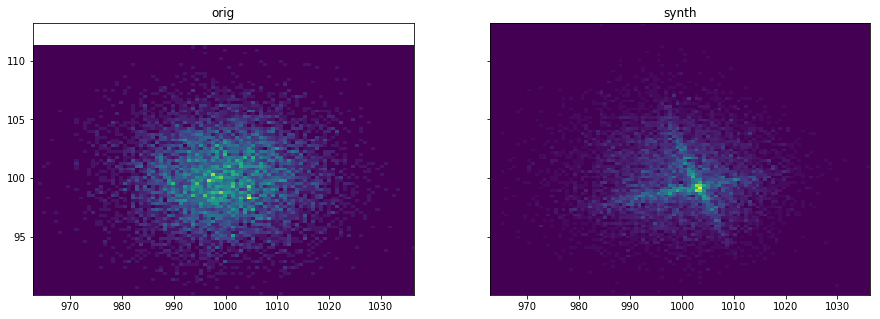

In [16]:
synthesize_and_plot(data, 'ball')

### Gauss "ball" around of zero

In [17]:
data = create_ball(x_mean=0, x_std=100, y_mean=0, y_std=10, size=10000)

took 16.647888898849487 s


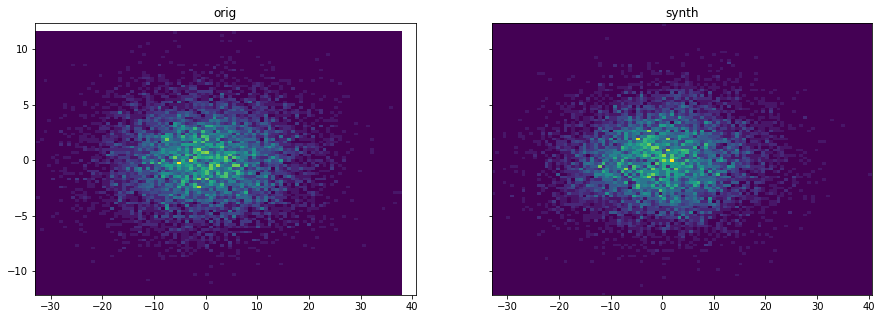

In [18]:
synthesize_and_plot(data, 'ball_ext')

### Line of noise that far from zero

In [19]:
data = create_line(x_range=(0, 1000), intercept=100, slope=-0.1, y_std=10, size=10000)

took 16.487668991088867 s


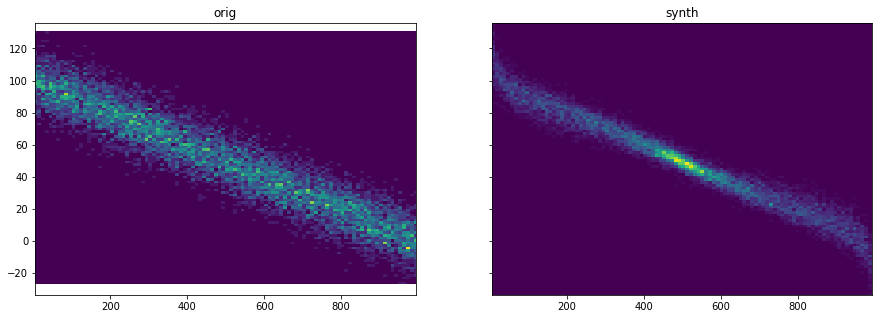

In [20]:
synthesize_and_plot(data, 'line')

### Line of noise that comes from zero

In [21]:
data = create_line(x_range=(0, 1000), intercept=0, slope=0.1, y_std=10, size=10000)

took 16.146747827529907 s


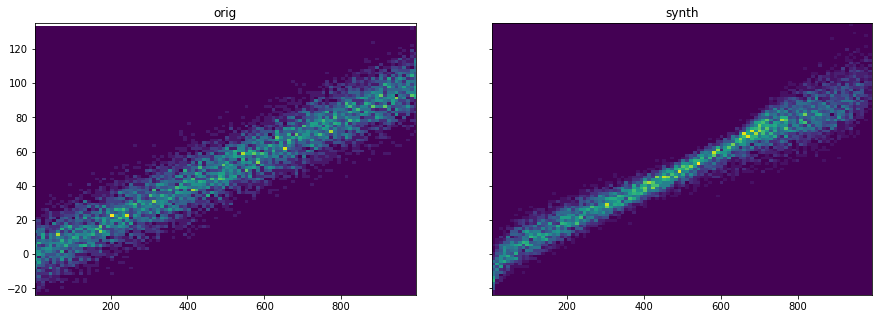

In [22]:
synthesize_and_plot(data, 'line_ext')

### Power law distribution

In [23]:
data = create_power_law_distribution(a=0.5, scale=1000, size=10000)

took 14.924680233001709 s


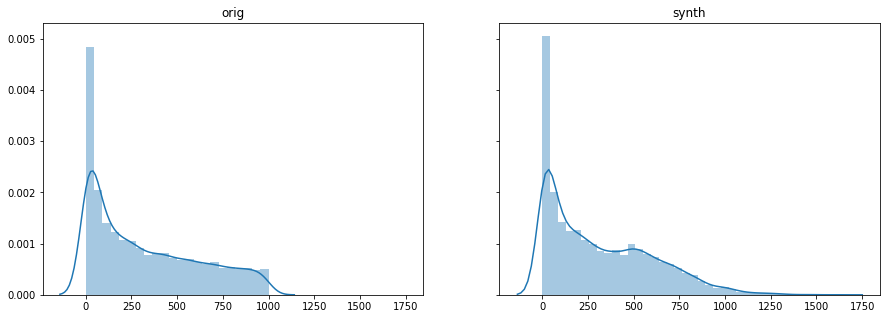

In [24]:
synthesize_and_plot(data, 'power_law')

### Conditional distribution

In [25]:
data = create_conditional_distibution((10,2), (20, 5), (30, 1), size=10000)

took 18.301303148269653 s


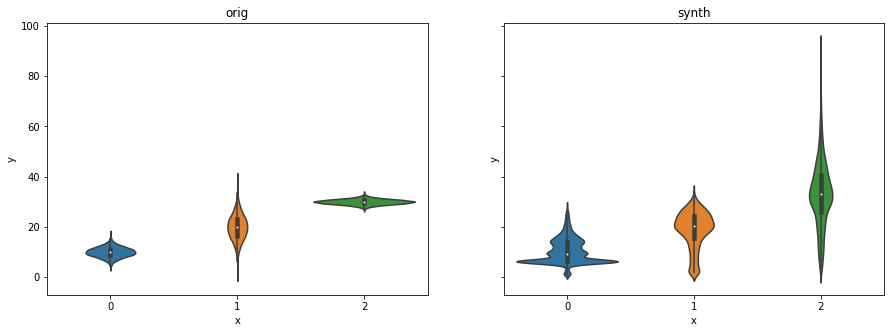

In [26]:
synthesize_and_plot(data, 'conditional')

### Bernoulli distribution

In [27]:
data = create_bernoulli_distribution(ratio=0.5, size=10000)

took 15.988749027252197 s


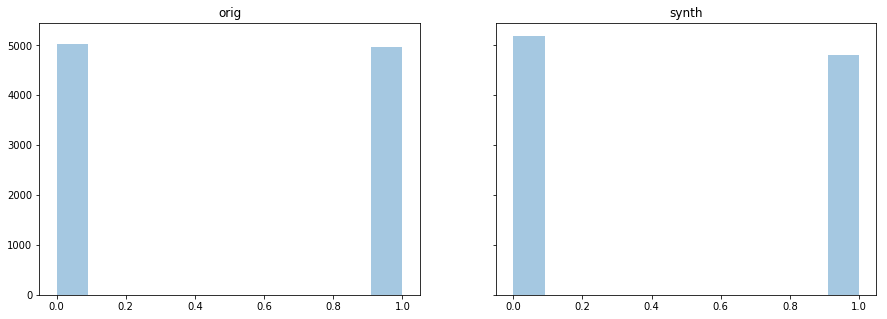

In [28]:
synthesize_and_plot(data, 'bernoulli_50/50')

In [29]:
data = create_bernoulli_distribution(ratio=0.2, size=10000)

took 16.415902137756348 s


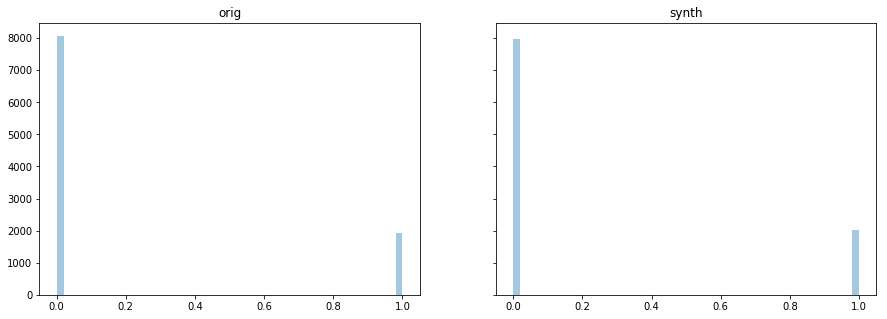

In [30]:
synthesize_and_plot(data, 'bernoulli_20/80')

### Categorical distribution

In [31]:
data = create_unifom_categorical(n_classes=10, size=10000)

took 16.73431396484375 s


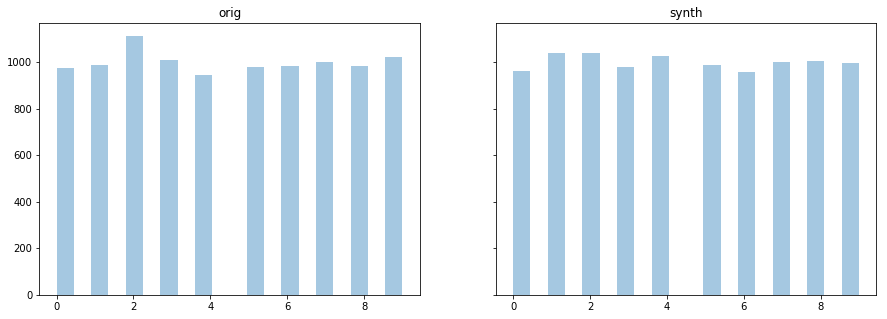

In [32]:
synthesize_and_plot(data, 'categorical_uniform')

In [43]:
data = create_power_law_categorical(n_classes=10, size=10000)

took 26.163650035858154 s


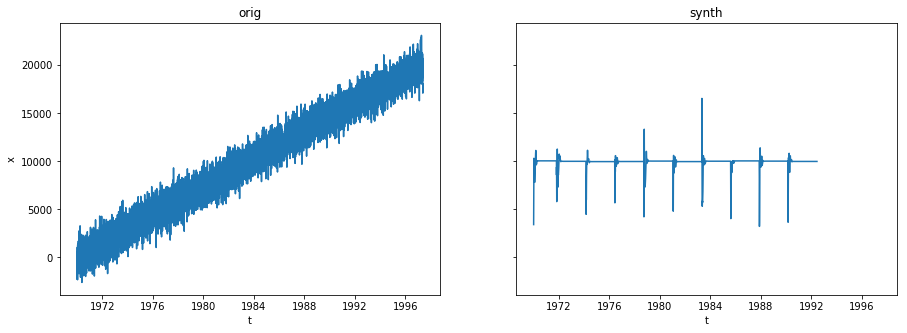

In [44]:
synthesize_and_plot(data, 'categorical_powerlaw')


took 26.163650035858154 s


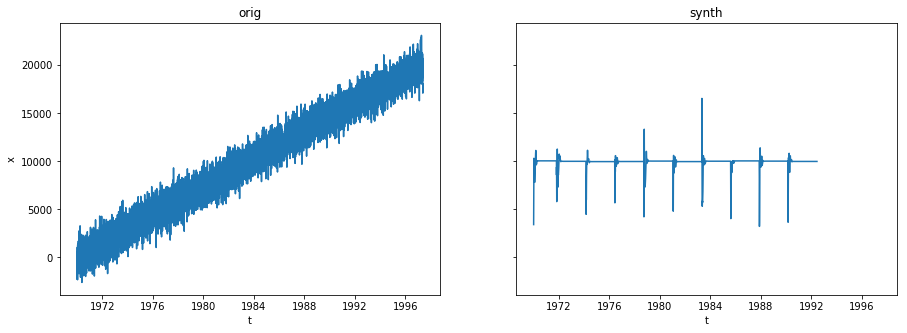

In [63]:
data = create_time_series_data(func=additive_linear(a=2., b=5., sd=1e3), length=10000)


took 26.163650035858154 s


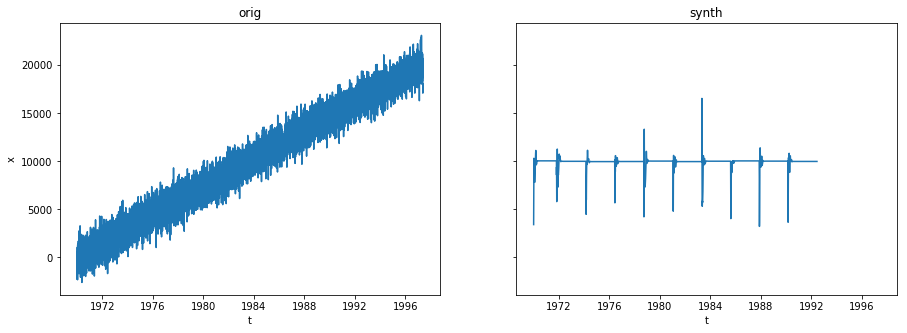

In [64]:
synthesize_and_plot(data, "trend_linear", n_iter=100, identifier_label="id", lstm_mode=2, sd=1e3, 
                    time_series=True, time_unit="d")


took 26.163650035858154 s


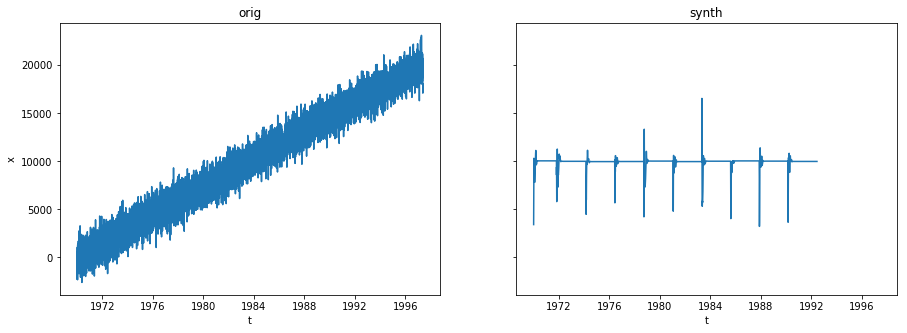

In [52]:
data = create_time_series_data(func=additive_sine(a=10, p=1000, sd=1.), length=10000)


took 26.163650035858154 s


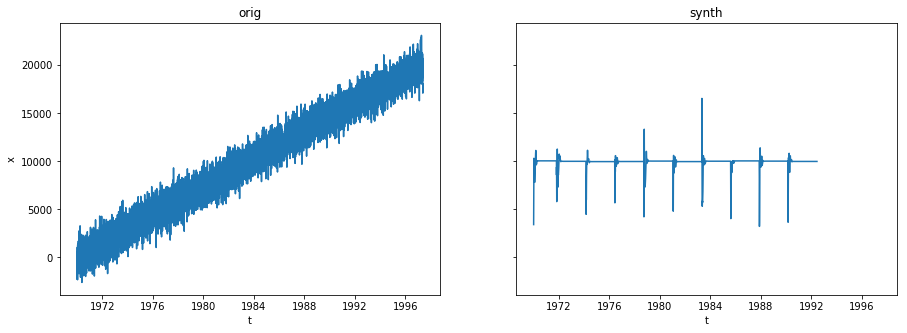

In [53]:
synthesize_and_plot(data, "cyclical_sinusoidal", identifier_label="id", lstm_mode=2, sd=1.,
                    time_series=True, time_unit="d")


took 26.163650035858154 s


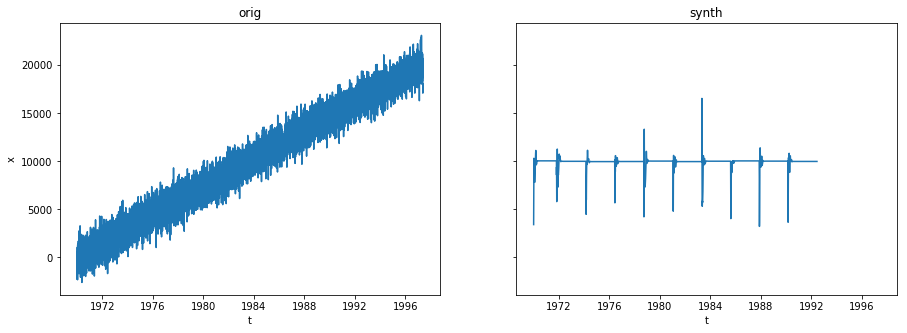

In [54]:
data = create_time_series_data(func=add_series(additive_sine(a=20, p=1000, sd=5.), 
                                               additive_sine(a=5, p=200, sd=1.)), 
                               length=10000)


took 26.163650035858154 s


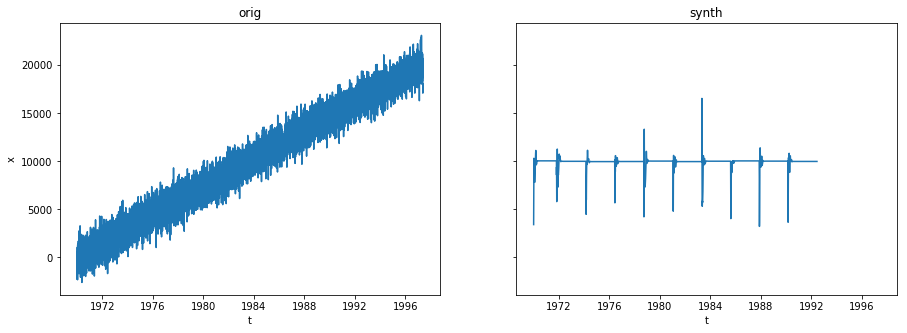

In [ ]:
synthesize_and_plot(data, "cyclical_and_seasonal_sinusoidal", identifier_label="id", lstm_mode=2, 
                    sd=sqrt(1.**2 + 5**2), time_series=True, time_unit="d")


took 26.163650035858154 s


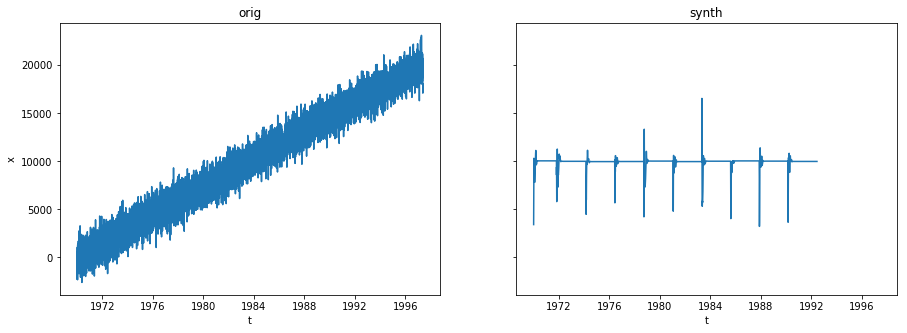

In [35]:
evaluation.write_metrics()